In [8]:
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


In [9]:
#params

plot_N2_profiles=True


In [10]:
config='EU36'
case='MPC001'
freq='1d'
year='2011'

list_dates=['m03d15','m09d15']

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'


In [11]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [16]:
def compute_N2(tem,sal,e3w,pdep):
    tem_up=tem
    sal_up=sal
    tem_down=tem.shift(deptht=-1)
    sal_down=sal.shift(deptht=-1)
    zt=0.5*(tem_up+tem_down)
    zs=0.5*(sal_up+sal_down)
    zh=pdep
    zht=zh.rename({'nav_lev':'deptht'})
    e3=e3w
    e3t=e3.rename({'nav_lev':'deptht'})
    zalbet = (((-0.255019e-07*zt+0.298357e-05)*zt-0.203814e-03)*zt+0.170907e-01+0.665157e-01+(-0.678662e-05*zs-0.846960e-04*zt+0.378110e-02)*zs+(-0.302285e-13*zht-0.251520e-11*zs+0.512857e-12*zt*zt)*zht-0.164759e-06*zs+(0.791325e-08*zt-0.933746e-06)*zt+0.380374e-04)*zht
    zbeta = ((-0.415613e-09*zt+0.555579e-07)*zt-0.301985e-05)*zt+0.785567e-03+(0.515032e-08*zs+0.788212e-08*zt-0.356603e-06)*zs+((0.121551e-17*zht-0.602281e-15*zs-0.175379e-14*zt+0.176621e-12)*zht+0.408195e-10*zs+ (- 0.213127e-11*zt+0.192867e-09)*zt-0.121555e-07)*zht
    bn2=e3t*zbeta*(zalbet *(tem_up-tem_down) - (sal_up - sal_down))
    bn2.attrs['units'] = 's-1'
    return bn2
    

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


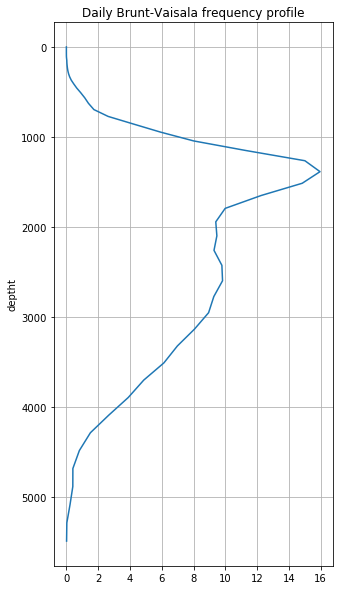

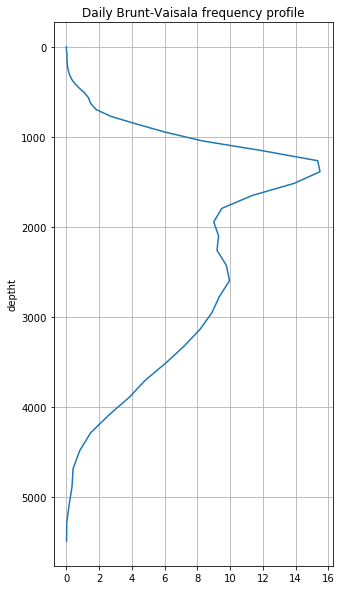

In [19]:
if plot_N2_profiles==True:
    for date in list_dates:
        ds=xr.open_dataset(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+str(date)+'.'+str(freq)+'_gridT.nc', chunks={'x':700,'y':1000,'time_counter':1,'deptht':1})
        tem=ds.votemper
        sal=ds.vosaline
        mask=dsmask.tmask[0]
        e3w=dsmask.e3w_0[0]
        gdepw=dsmask.gdepw_0[0]
        bn2=compute_N2(tem,sal,e3w,gdepw)
        fig, ax = plt.subplots(1,1,figsize=(5,10))
        bn2.mean(dim='x').mean(dim='y').plot(y='deptht', yincrease=False)
        ax.set_title(date)
        plt.grid()
        ax.set_title('Daily Brunt-Vaisala frequency profile')
        plt.savefig('Plots/EU36/Profiles/'+config+'-'+case+'y'+str(year)+str(date)+'_mean-N2-profile.png')